In [1]:
import os
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
DEFAULT_ROOT_DIR = "/project/simmons_hts/kxu/hest/eval/ST_pred_results"

def summarize_runs(root_dir=DEFAULT_ROOT_DIR):
    """
    List runs in ST_pred_results and summarize config.json details along with
    highest Pearson mean and std from dataset_results.json.

    Args:
        root_dir (str): Root directory containing the run folders.

    Returns:
        pd.DataFrame: Summary dataframe for all runs.
    """
    summary = []

    for run in os.listdir(root_dir):
        run_path = os.path.join(root_dir, run)
        if not os.path.isdir(run_path) or not run.startswith("run_"):
            continue

        config_data = {}
        gene_list = ""
        config_found = False
        best_model = None

        # Search for config.json
        for dirpath, _, filenames in os.walk(run_path):
            if "config.json" in filenames:
                config_path = os.path.join(dirpath, "config.json")
                with open(config_path, 'r') as f:
                    config_data = json.load(f)
                    gene_list = config_data.get("gene_list", "")
                config_found = True
                break

        # Search for dataset_results.json
        dataset_results_path = os.path.join(run_path, "dataset_results.json")
        highest_mean = None
        highest_std = None
        if os.path.isfile(dataset_results_path):
            with open(dataset_results_path, 'r') as f:
                data = json.load(f)
                all_results = data.get("results", [])[0].get("results", [])
                if all_results:
                    best_entry = max(all_results, key=lambda x: x["pearson_mean"])
                    highest_mean = best_entry["pearson_mean"]
                    highest_std = best_entry["pearson_std"]
                    best_model = best_entry['encoder_name']

        summary.append({
            "run": run,
            "gene_list": gene_list,
            "alpha": config_data.get("alpha"),
            "batch_size": config_data.get("batch_size"),
            "dimreduce": config_data.get("dimreduce"),
            "encoders": ", ".join(config_data.get("encoders", [])) if config_found else None,
            "normalize": config_data.get("normalize"),
            "latent_dim": config_data.get("latent_dim"),
            "method": config_data.get("method"),
            "dataset": config_data.get("datasets", [None])[0] if config_found else None,
            "best_model":best_model,
            "highest_pearson_mean": highest_mean,
            "highest_pearson_std": highest_std
        })

    df = pd.DataFrame(summary)
    return df

def visualize_dataset_results(run, root_dir=DEFAULT_ROOT_DIR):
    """
    Visualize dataset results for the specified run as a point plot with error bars.
    Includes the gene list name from config.json and counts genes if the file exists.
    Returns the matplotlib Figure object.

    Args:
        run (str): Run folder name to visualize.
        root_dir (str): Root directory containing the run folders.

    Returns:
        matplotlib.figure.Figure: The figure object containing the plot.
    """
    run_path = os.path.join(root_dir, run, "dataset_results.json")
    print(run_path)

    if not os.path.isfile(run_path):
        print(f"Dataset results not found for {run}")
        return None

    with open(run_path, 'r') as f:
        data = json.load(f)

    # Extract per-dataset results (assume first dataset)
    dataset_results = data.get("results", [])[0]
    dataset_name = dataset_results.get("dataset_name", "Unknown")

    encoders = [r["encoder_name"] for r in dataset_results.get("results", [])]
    pearson_means = [r["pearson_mean"] for r in dataset_results.get("results", [])]
    pearson_stds = [r["pearson_std"] for r in dataset_results.get("results", [])]

    # Find config.json to extract gene_list
    gene_list_name = ""
    gene_count = None
    for dirpath, _, filenames in os.walk(os.path.join(root_dir, run)):
        if "config.json" in filenames:
            config_path = os.path.join(dirpath, "config.json")
            with open(config_path, 'r') as cf:
                config = json.load(cf)
                gene_list_name = config.get("gene_list", "")

            # Try counting number of genes if file exists
            if gene_list_name:
                gene_list_path = os.path.join(os.path.dirname(config_path), gene_list_name)
                if not os.path.isfile(gene_list_path):
                    gene_list_path = gene_list_name  # try absolute path if stored
                if os.path.isfile(gene_list_path):
                    with open(gene_list_path, 'r') as gf:
                        genes = json.load(gf)
                        gene_count = len(genes) if isinstance(genes, list) else None
            break

    # Plot: Point Plot with Error Bars
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.errorbar(encoders, pearson_means, yerr=pearson_stds,
                fmt='o', capsize=5, markersize=8, linestyle='')

    ax.set_ylabel('Pearson Correlation')
    title = f"Dataset: {dataset_name}"
    if gene_list_name:
        title += f" | Gene List: {gene_list_name}"
    if gene_count is not None:
        title += f" ({gene_count} genes)"
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    return fig


def print_first_config(run, root_dir=DEFAULT_ROOT_DIR):
    """
    Find and print the contents of the first config.json file in the folder tree.

    Args:
        run (str): Run folder name to search for config.json.
        root_dir (str): Root directory containing the run folders.
    """
    run_path = os.path.join(root_dir, run)
    for dirpath, _, filenames in os.walk(run_path):
        if "config.json" in filenames:
            config_path = os.path.join(dirpath, "config.json")
            print(f"Found config.json at: {config_path}")
            with open(config_path, 'r') as f:
                config = json.load(f)
                print(json.dumps(config, indent=4))
            return
    print("No config.json found.")


In [3]:
def extract_best_model_gene_corrs(run, root_dir=DEFAULT_ROOT_DIR):
    """
    For a given run, find the best model (highest Pearson mean in dataset_results.json),
    print its summary stats, then load its results_kfold.json and extract per-gene
    correlations including per-split values.

    Args:
        run (str): Run folder name (e.g. 'run_25-09-05-16-12-17').
        root_dir (str): Root directory containing run folders.

    Returns:
        tuple: (best_model_info, dataset_name, df_genes, gene_list_name)
            best_model_info: dict with encoder_name, pearson_mean, pearson_std
            df_genes: DataFrame with columns ['gene', 'mean_corr', 'std_corr', 'corr_per_split']
            gene_list_name: name of the gene list used for this run
    """
    import os, json, pandas as pd

    run_path = os.path.join(root_dir, run)
    dataset_results_path = os.path.join(run_path, "dataset_results.json")

    if not os.path.isfile(dataset_results_path):
        raise FileNotFoundError(f"dataset_results.json not found for run {run}")

    # Step 1: Load dataset_results.json
    with open(dataset_results_path, "r") as f:
        dataset_results = json.load(f)

    dataset_entry = dataset_results.get("results", [])[0]
    dataset_name = dataset_entry.get("dataset_name", "Unknown")
    all_models = dataset_entry.get("results", [])

    if not all_models:
        raise ValueError(f"No model results found in {dataset_results_path}")

    # Step 2: Find best model
    best_model = max(all_models, key=lambda x: x["pearson_mean"])
    best_model_name = best_model["encoder_name"]

    print(f"Best model for dataset {dataset_name}:")
    print(f"encoder_name: {best_model_name}")
    print(f"pearson_mean: {best_model['pearson_mean']}")
    print(f"pearson_std: {best_model['pearson_std']}")

    best_model_info = {
        "encoder_name": best_model_name,
        "pearson_mean": best_model["pearson_mean"],
        "pearson_std": best_model["pearson_std"]
    }

    # Step 2a: Get gene_list_name from config.json
    gene_list_name = ""
    for dirpath, _, filenames in os.walk(run_path):
        if "config.json" in filenames:
            config_path = os.path.join(dirpath, "config.json")
            with open(config_path, 'r') as cf:
                config = json.load(cf)
                gene_list_name = config.get("gene_list", "")
                print(f"Genes predicted from list: {gene_list_name}")
            break

    # Step 3: Path to results_kfold.json
    results_kfold_path = os.path.join(run_path, dataset_name, best_model_name, "results_kfold.json")

    if not os.path.isfile(results_kfold_path):
        raise FileNotFoundError(f"results_kfold.json not found at {results_kfold_path}")

    # Step 4: Load results_kfold.json
    with open(results_kfold_path, "r") as f:
        kfold_data = json.load(f)

    pearson_corrs = kfold_data.get("pearson_corrs", [])
    records = [
        {
            "gene": g["name"],
            "mean_corr": g.get("mean"),
            "std_corr": g.get("std"),
            "corr_per_split": g.get("pearson_corrs", [])
        }
        for g in pearson_corrs if "name" in g
    ]

    df_genes = pd.DataFrame(records)

    print(f"Number of genes predicted: {len(df_genes)}")
    print(f"Number of splits per gene: {len(df_genes['corr_per_split'].iloc[0]) if len(df_genes) > 0 else 0}")

    return best_model_info, dataset_name, df_genes, gene_list_name


In [4]:
def plot_gene_correlation_histogram(run, root_dir=DEFAULT_ROOT_DIR, bins=20):
    """
    Extract the best model for a run and plot a histogram of per-gene mean correlations.
    Returns the DataFrame of per-gene correlations and the figure object for further inspection or saving.

    Args:
        run (str): Run folder name.
        root_dir (str): Root directory containing run folders.
        bins (int, optional): Number of bins for the histogram.

    Returns:
        fig (matplotlib.figure.Figure): Figure object of the histogram.
    """
    import matplotlib.pyplot as plt

    # Step 1: Extract best model info and gene correlations
    best_model_info, dataset_name, df_genes, gene_list_name = extract_best_model_gene_corrs(run, root_dir=root_dir)

    if df_genes.empty:
        print("No gene correlation data to plot.")
        return df_genes, None

    # Step 2: Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(df_genes['mean_corr'], bins=bins, color='skyblue', edgecolor='black')
    ax.set_xlabel('Mean Pearson Correlation')
    ax.set_ylabel('Number of Genes')

    title = (
        f"Gene Correlation | Data: {dataset_name} | Model: {best_model_info['encoder_name']} "
        f"| Mean: {best_model_info['pearson_mean']:.2f} | Std: {best_model_info['pearson_std']:.2f}"
    )

    if gene_list_name:
        name_display = gene_list_name.replace('.json', '')
        title += f" | Gene List: {name_display} ({len(df_genes)} genes)"

    ax.set_title(title)
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.15, top=0.85)  # extra padding for labels/title

    return fig


In [5]:
def plot_gene_correlation_barplot(run, root_dir=DEFAULT_ROOT_DIR):
    """
    Extract the best model for a run and plot a horizontal bar plot of per-gene mean correlations.
    Gene names are on the y-axis, sorted so that the gene with highest correlation is at the top.
    Standard deviation is shown as error bars.

    Args:
        run (str): Run folder name.
        root_dir (str): Root directory containing run folders.

    Returns:
        fig (matplotlib.figure.Figure): Figure object of the bar plot.
    """
    import matplotlib.pyplot as plt

    # Step 1: Extract best model info and gene correlations
    best_model_info, dataset_name, df_genes, gene_list_name = extract_best_model_gene_corrs(run, root_dir=root_dir)

    if df_genes.empty:
        print("No gene correlation data to plot.")
        return df_genes, None

    # Step 2: Sort by mean correlation ascending for horizontal bar plot
    df_genes_sorted = df_genes.sort_values('mean_corr', ascending=True)

    # Step 3: Create figure
    fig, ax = plt.subplots(figsize=(10, max(6, len(df_genes_sorted) * 0.3)))  # scale height with number of genes
    ax.barh(
        df_genes_sorted['gene'],
        df_genes_sorted['mean_corr'],
        xerr=df_genes_sorted['std_corr'],
        color='skyblue',
        ecolor='black',
        capsize=4,
        label='SD'
    )

    ax.set_xlabel('Mean Pearson Correlation')
    ax.set_ylabel('Gene')

    title = (
        f"Gene Correlation | Data: {dataset_name} | Model: {best_model_info['encoder_name']} "
        f"| Mean: {best_model_info['pearson_mean']:.2f} | Std: {best_model_info['pearson_std']:.2f}"
    )

    if gene_list_name:
        name_display = gene_list_name.replace('.json', '')
        title += f" | Gene List: {name_display} ({len(df_genes_sorted)} genes)"

    ax.set_title(title)
    ax.legend(title='Error Bar')
    plt.tight_layout()

    return fig


In [6]:
df_summary = summarize_runs()
df_summary.to_csv("/project/simmons_hts/kxu/hest/eval/experiment_log.csv")
df_summary

,run,gene_list,alpha,batch_size,dimreduce,encoders,normalize,latent_dim,method,dataset,best_model,highest_pearson_mean,highest_pearson_std
0,run_25-12-05-11-44-11,all_genes.json,None,512,PCA,"hibou_large, hoptimus0, hoptimus1, virchow2, u...",True,256,ridge,VisiumR1-6,None,NaN,NaN
1,run_25-10-11-16-22-39,all_genes.json,None,256,PCA,"conch_v1_5, uni_v2, uni_v1, hoptimus1, resnet5...",True,256,ridge,broad,hoptimus0,0.674141,0.031085
2,run_25-09-10-17-09-16,full_panel_genes.json,None,128,PCA,"uni_v1, resnet50, ctranspath, phikon, phikon_v...",True,64,ridge,XeniumPR1,hoptimus0,0.504898,0.084318
3,run_25-10-27-18-43-26,all_genes.json,None,256,PCA,"hoptimus0, hoptimus1, virchow2, hibou_large",True,256,ridge,XeniumPR3,virchow2,0.391768,0.202134
4,run_25-10-10-11-57-55,var_50genes.json,None,256,PCA,"uni_v2, uni_v1, hibou_large, gigapath, virchow...",True,256,ridge,pilot,uni_v2,0.081877,0.005876
5,run_25-10-24-20-12-16,common_genes_0.1.json,None,512,PCA,"hoptimus0, hoptimus1, virchow2, hibou_large, u...",True,256,ridge,XeniumPR3,virchow2,0.551196,0.133002
6,run_25-10-27-16-11-18,common_genes_0.1.json,None,512,PCA,"hoptimus0, hoptimus1, virchow2, hibou_large, u...",True,256,ridge,XeniumPR3,virchow2,0.551195,0.133003
7,run_25-11-10-23-31-01,all_genes.json,None,512,PCA,"hoptimus1, hoptimus0, virchow2, hibou_large",True,256,ridge,XeniumPR_LOOCV,hoptimus1,0.454505,0.200964
8,run_25-10-17-19-48-38,all_genes.json,None,256,PCA,"hoptimus0, hoptimus1, virchow2, hibou_large, u...",True,256,ridge,XeniumPR1_50um,hoptimus1,0.393534,0.198990
9,run_25-12-05-15-31-09,var_1000genes.json,None,512,PCA,gigapath,True,256,ridge,VisiumR1-6,None,NaN,NaN


### cell specific genes

Selected RUNS: run_25-09-05-16-12-17
run                                                 run_25-09-05-16-12-17
gene_list                                        cell_specific_genes.json
alpha                                                                None
batch_size                                                            128
dimreduce                                                             PCA
encoders                uni_v1, resnet50, ctranspath, phikon, phikon_v...
normalize                                                            True
latent_dim                                                            256
method                                                              ridge
dataset                                                         XeniumPR1
highest_pearson_mean                                             0.602295
highest_pearson_std                                              0.097945
Name: 8, dtype: object
/project/simmons_hts/kxu/hest/eval/ST_pred_results/r

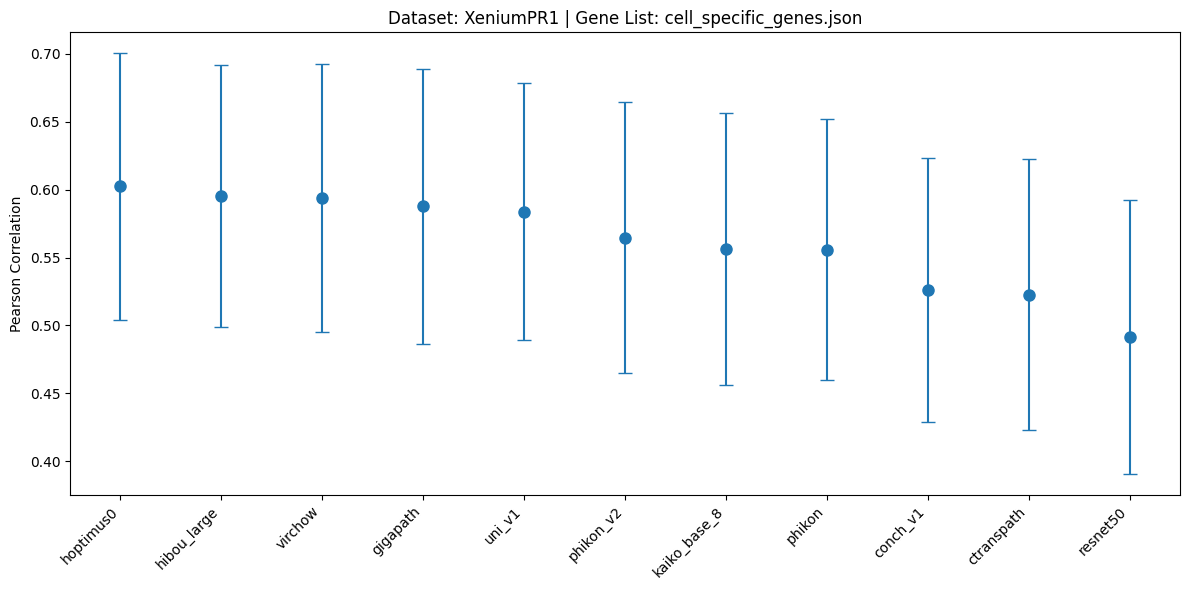

Best model for dataset XeniumPR1:
encoder_name: hoptimus0
pearson_mean: 0.6022954884328481
pearson_std: 0.0979454705464497
Genes predicted from list: cell_specific_genes.json
Number of genes predicted: 47
Number of splits per gene: 15
       gene  mean_corr  std_corr  \
0     EPCAM   0.878779  0.136930   
1      MUC2   0.837875  0.155476   
2      CDX2   0.823325  0.179543   
3  ADAMDEC1   0.813156  0.105875   
4      CD3D   0.785463  0.101186   

                                      corr_per_split  
0  [0.9648251356778832, 0.857068658549762, 0.9298...  
1  [0.9344537366565437, 0.8566383285493804, 0.928...  
2  [0.9564316594571458, 0.5600687193603838, 0.902...  
3  [0.9345796735078444, 0.5495634319351435, 0.918...  
4  [0.8429689645355309, 0.7486419062047408, 0.839...  
Best model for dataset XeniumPR1:
encoder_name: hoptimus0
pearson_mean: 0.6022954884328481
pearson_std: 0.0979454705464497
Genes predicted from list: cell_specific_genes.json
Number of genes predicted: 47
Number of spl

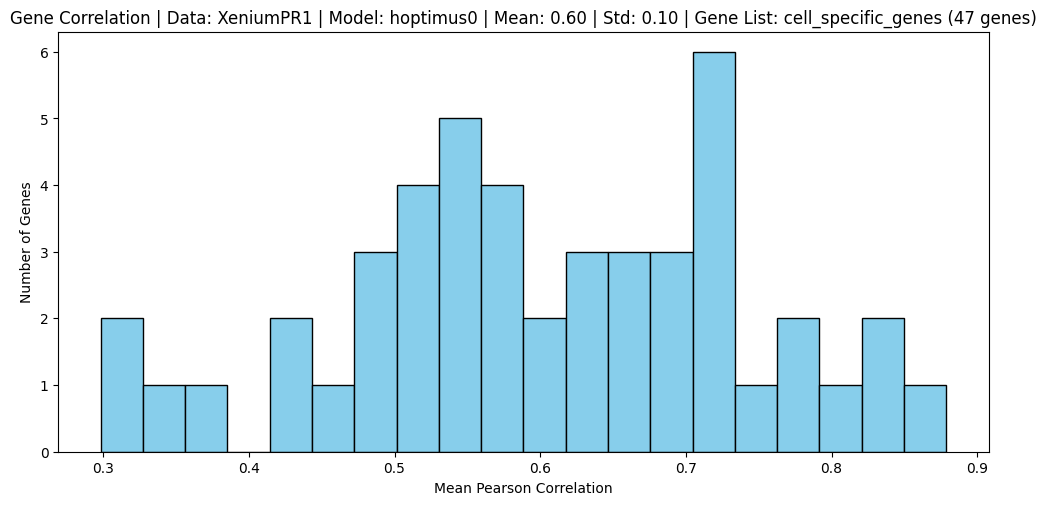

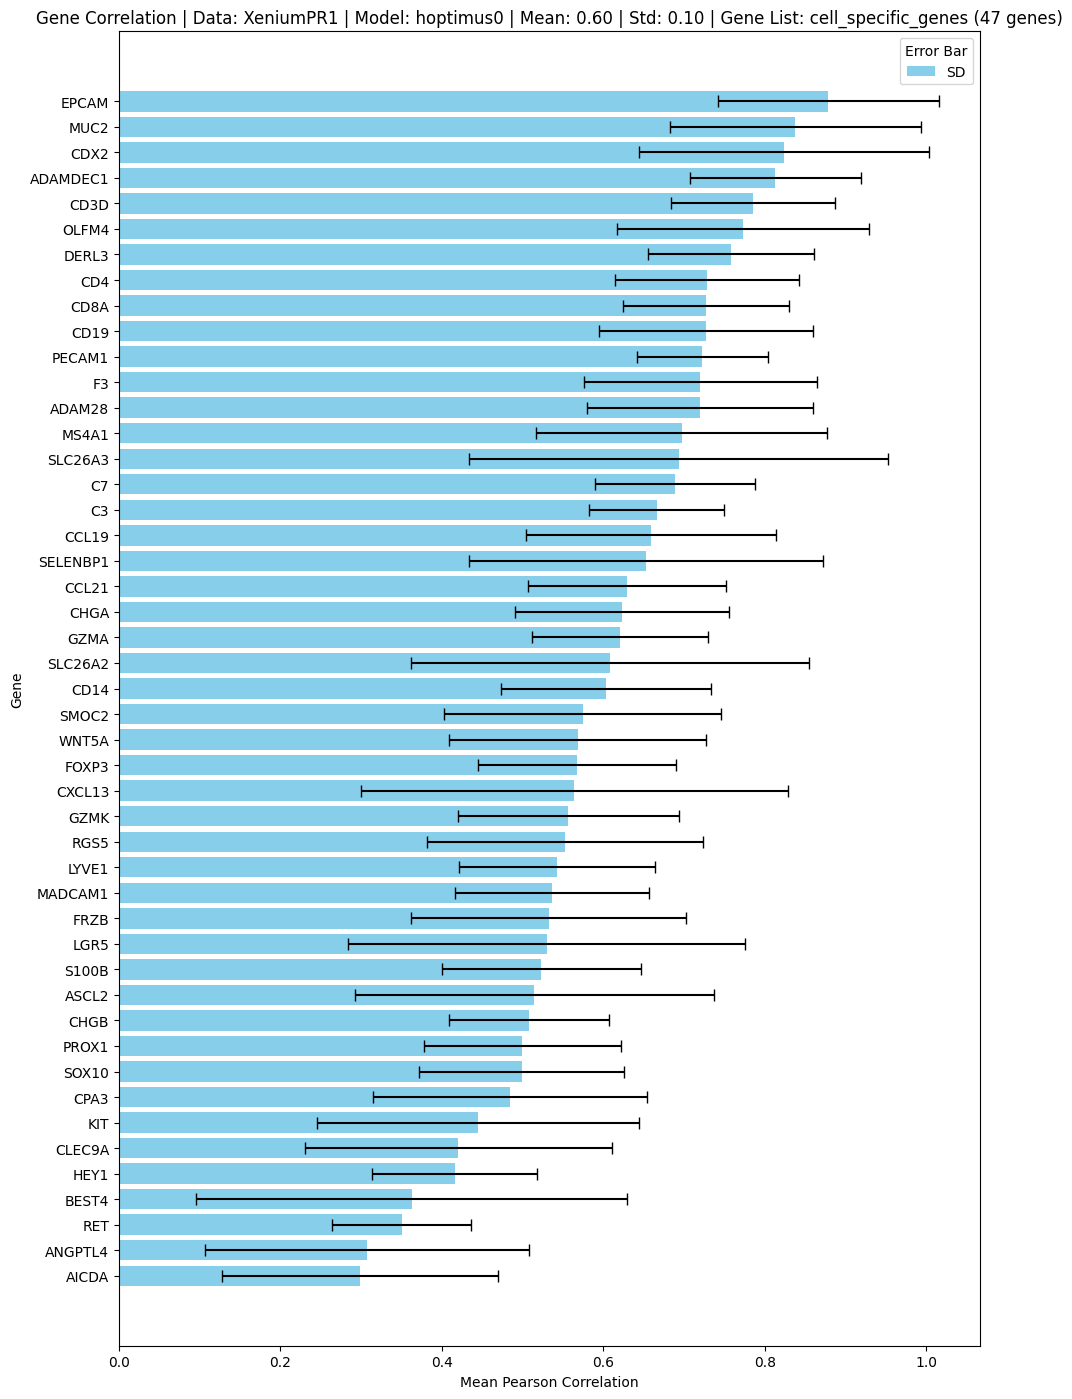

In [181]:
# Select the run 
RUN_INDEX = 8
RUN = df_summary.loc[RUN_INDEX, 'run']  # wrap in list to match expected format
print("Selected RUNS:", RUN)
print(df_summary.loc[RUN_INDEX])

visualize_dataset_results(RUN)
#print_first_config(runs=RUNS)

best_model, dataset, df_genes, gene_list = extract_best_model_gene_corrs(RUN)
print(df_genes.head())
plot_gene_correlation_histogram(RUN)
plot_gene_correlation_barplot(RUN)

df_genes_cell = df_genes

### full panel genes

Selected RUNS: run_25-09-06-14-12-40
run                                                 run_25-09-06-14-12-40
gene_list                                           full_panel_genes.json
alpha                                                                None
batch_size                                                            128
dimreduce                                                             PCA
encoders                uni_v1, resnet50, ctranspath, phikon, phikon_v...
normalize                                                            True
latent_dim                                                            256
method                                                              ridge
dataset                                                         XeniumPR1
highest_pearson_mean                                             0.526018
highest_pearson_std                                               0.08617
Name: 2, dtype: object
/project/simmons_hts/kxu/hest/eval/ST_pred_results/r

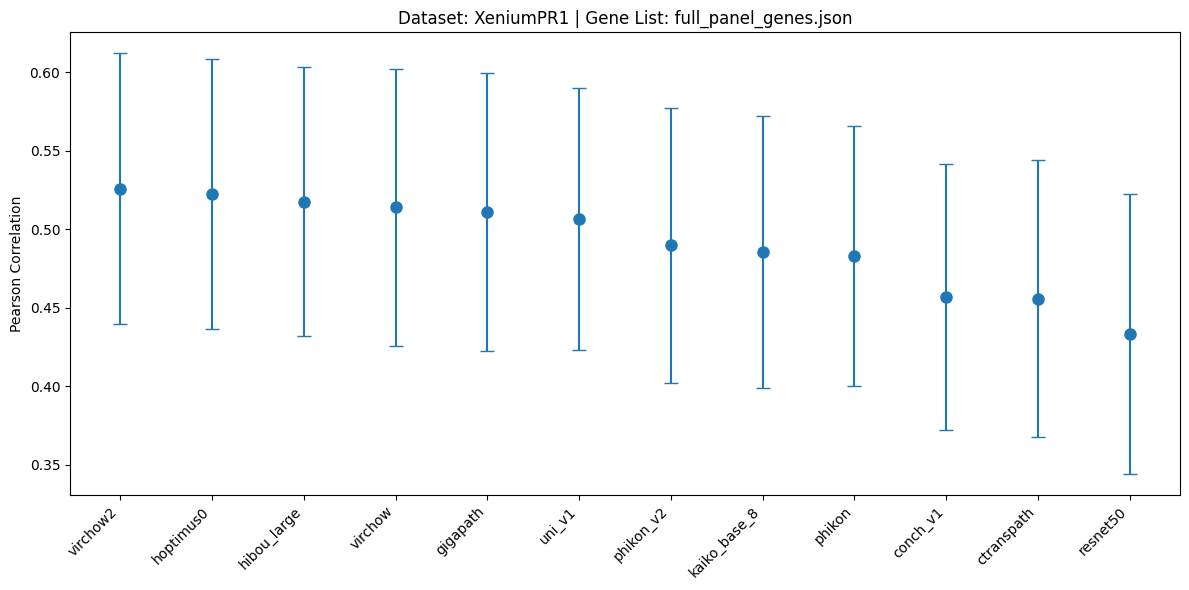

Best model for dataset XeniumPR1:
encoder_name: virchow2
pearson_mean: 0.526017642030283
pearson_std: 0.08616952315230404
Genes predicted from list: full_panel_genes.json
Number of genes predicted: 363
Number of splits per gene: 15
    gene  mean_corr  std_corr  \
0  EPCAM   0.880192  0.130616   
1  FCGBP   0.874212  0.104080   
2   CDH1   0.855118  0.142134   
3   MUC2   0.836970  0.163474   
4  PTPRC   0.826504  0.079118   

                                      corr_per_split  
0  [0.9614250053485429, 0.8554476589197699, 0.943...  
1  [0.9622005431221452, 0.8199054866946867, 0.938...  
2  [0.9579847840197014, 0.6874527435595037, 0.933...  
3  [0.9367316596674853, 0.8545906061262525, 0.926...  
4  [0.866304864878388, 0.8596610288881009, 0.8661...  
Best model for dataset XeniumPR1:
encoder_name: virchow2
pearson_mean: 0.526017642030283
pearson_std: 0.08616952315230404
Genes predicted from list: full_panel_genes.json
Number of genes predicted: 363
Number of splits per gene: 15
Best mo

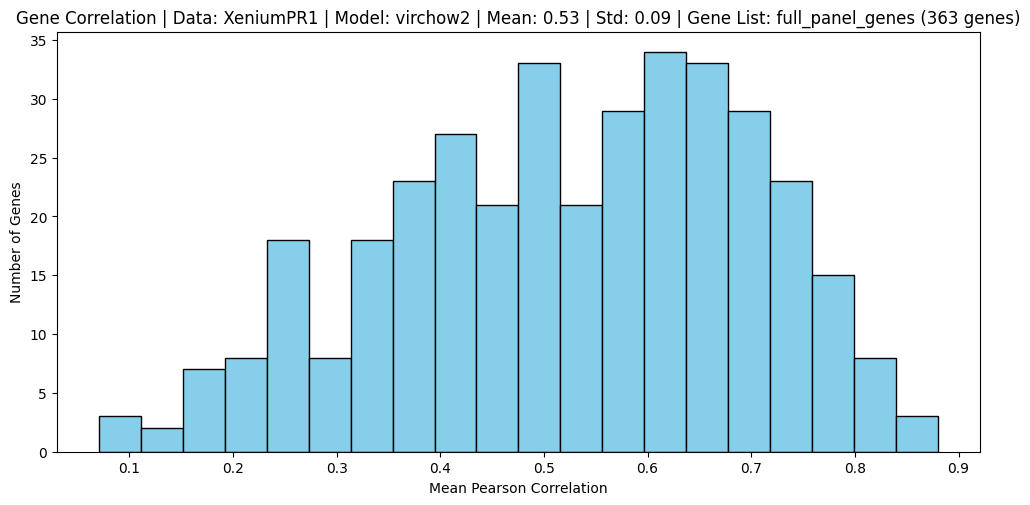

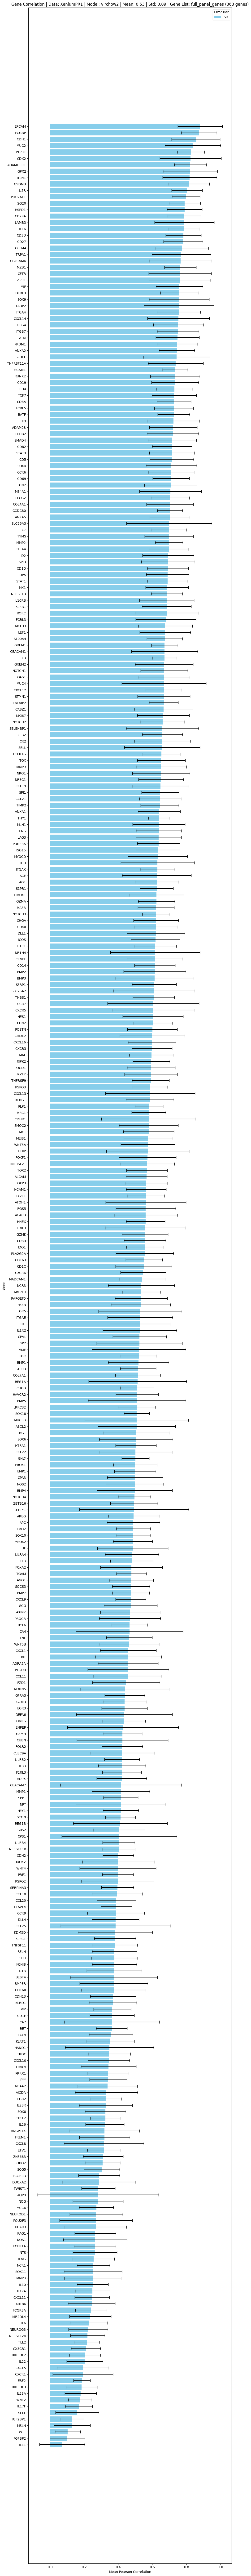

In [182]:
# Select the run 
RUN_INDEX = 2
RUN = df_summary.loc[RUN_INDEX, 'run']  # wrap in list to match expected format
print("Selected RUNS:", RUN)
print(df_summary.loc[RUN_INDEX])

plot0 = visualize_dataset_results(RUN)
#print_first_config(runs=RUNS)

best_model, dataset, df_genes, gene_list = extract_best_model_gene_corrs(RUN)
print(df_genes.head())
plot1 = plot_gene_correlation_histogram(RUN)
plot2 = plot_gene_correlation_barplot(RUN)
df_genes_full_panel = df_genes

#### Compare cor between cell specific & full panel genes

In [183]:
# Merge df_genes_cell and df_genes_full_panel on 'gene'
df_merged = df_genes_cell.merge(
    df_genes_full_panel,
    on="gene",
    how="inner",
    suffixes=("_cell", "_full_panel")
)

# Preview
display(df_merged.head())

mean_cell = df_merged["mean_corr_cell"].mean()
mean_full_panel = df_merged["mean_corr_full_panel"].mean()

print(f"Mean correlation (cell): {mean_cell:.4f}")
print(f"Mean correlation (full panel): {mean_full_panel:.4f}")

,gene,mean_corr_cell,std_corr_cell,corr_per_split_cell,mean_corr_full_panel,std_corr_full_panel,corr_per_split_full_panel
0,EPCAM,0.878779,0.136930,"[0.9648251356778832, 0.857068658549762, 0.9298...",0.880192,0.130616,"[0.9614250053485429, 0.8554476589197699, 0.943..."
1,MUC2,0.837875,0.155476,"[0.9344537366565437, 0.8566383285493804, 0.928...",0.836970,0.163474,"[0.9367316596674853, 0.8545906061262525, 0.926..."
2,CDX2,0.823325,0.179543,"[0.9564316594571458, 0.5600687193603838, 0.902...",0.823589,0.179958,"[0.9529854580848371, 0.58027311019922, 0.91522..."
3,ADAMDEC1,0.813156,0.105875,"[0.9345796735078444, 0.5495634319351435, 0.918...",0.822899,0.093149,"[0.9362458930066981, 0.6220899553144075, 0.923..."
4,CD3D,0.785463,0.101186,"[0.8429689645355309, 0.7486419062047408, 0.839...",0.782528,0.104290,"[0.8255929345145112, 0.7396915155952183, 0.844..."


Mean correlation (cell): 0.6023
Mean correlation (full panel): 0.6071


The mean correlation is very similar. So it doesn't matter if I just extract a subset of genes from full panel

## plot gene correlation barplot grouped by cell type or condition

In [184]:
# === Input Excel file ===
input_file = "/project/simmons_hts/kxu/hest/curated_gene_list.xlsx"

# Read Excel
df_meta = pd.read_excel(input_file)
df_meta

,480 panel full list,Unnamed: 1,Cell Type Specific,Where?,Unnamed: 4,Conditional,Where?.1
0,ACACB,NaN,EPCAM,epithelium,NaN,DEFA5,epithelium - ileum only
1,ACE,NaN,MUC2,epithelium,NaN,DEFA6,epithelium - ileum only
2,ACKR1,NaN,CHGA,epithelium,NaN,LEFTY1,epithelium - colon only
3,ADAM28,NaN,CHGB,epithelium,NaN,SPP1,macropages - inflammation only
4,ADAMDEC1,NaN,CDX2,epithelium,NaN,DUOX2,epithelium - inflammation only
...,...,...,...,...,...,...,...
475,XCL1,NaN,NaN,NaN,NaN,NaN,NaN
476,ZBTB16,NaN,NaN,NaN,NaN,NaN,NaN
477,ZEB2,NaN,NaN,NaN,NaN,NaN,NaN
478,ZG16,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
df_meta = df_meta.rename(columns={
    "Where?": "cell_type",
    "Where?.1": "condition"
})

In [186]:
# Step 3: Merge for cell type annotation
df_celltype = df_meta[["Cell Type Specific", "cell_type"]].dropna()
df_celltype = df_celltype.rename(columns={"Cell Type Specific": "gene"})
display(df_celltype.head())

df_genes_full_panel_annotated = df_genes_full_panel.merge(
    df_celltype,
    on="gene",
    how="left"  # keep all genes
)

# Step 4: Merge for condition annotation
df_condition = df_meta[["Conditional", "condition"]].dropna()
df_condition = df_condition.rename(columns={"Conditional": "gene"})

df_genes_full_panel_annotated = df_genes_full_panel_annotated.merge(
    df_condition,
    on="gene",
    how="left"  # keep all genes
)

df_genes_full_panel_annotated

,gene,cell_type
0,EPCAM,epithelium
1,MUC2,epithelium
2,CHGA,epithelium
3,CHGB,epithelium
4,CDX2,epithelium


,gene,mean_corr,std_corr,corr_per_split,cell_type,condition
0,EPCAM,0.880192,0.130616,"[0.9614250053485429, 0.8554476589197699, 0.943...",epithelium,NaN
1,FCGBP,0.874212,0.104080,"[0.9622005431221452, 0.8199054866946867, 0.938...",NaN,NaN
2,CDH1,0.855118,0.142134,"[0.9579847840197014, 0.6874527435595037, 0.933...",NaN,NaN
3,MUC2,0.836970,0.163474,"[0.9367316596674853, 0.8545906061262525, 0.926...",epithelium,NaN
4,PTPRC,0.826504,0.079118,"[0.866304864878388, 0.8596610288881009, 0.8661...",NaN,NaN
...,...,...,...,...,...,...
358,IGF2BP1,0.130389,0.067986,"[0.13093603569478346, 0.04851848974870358, 0.2...",NaN,NaN
359,MSLN,0.129950,0.106789,"[0.3257072309825532, 0.11897649330354831, 0.14...",NaN,NaN
360,WT1,0.103433,0.074384,"[0.12205286424033254, 0.019438738686855476, 0....",NaN,NaN
361,FGFBP2,0.102013,0.102774,"[0.01286588517257961, 0.037469260015991004, 0....",NaN,NaN


In [187]:
def plot_genes_grouped(df_genes, group_by='cell_type', show_mean=True):
    """
    Plot individual gene mean correlations grouped by a specified column (cell_type or condition).
    
    Args:
        df_genes (pd.DataFrame): Must contain 'gene', 'mean_corr', 'std_corr', and the grouping column.
        group_by (str): Column name to group by ('cell_type' or 'condition').
        show_mean (bool): Whether to show a horizontal line per group indicating mean correlation.
    
    Returns:
        matplotlib.figure.Figure: Figure object for further saving or manipulation.
    """
    if group_by not in ['cell_type', 'condition']:
        raise ValueError("group_by must be 'cell_type' or 'condition'")
    
    # Filter out rows where grouping column is NA
    df_plot = df_genes[df_genes[group_by].notna()].copy()
    
    # Compute average mean_corr per group for ordering
    group_order = df_plot.groupby(group_by)['mean_corr'].mean().sort_values(ascending=False).index.tolist()
    
    # Sort genes by group and descending mean_corr
    df_plot[f'{group_by}_ordered'] = pd.Categorical(df_plot[group_by], categories=group_order, ordered=True)
    df_plot = df_plot.sort_values([f'{group_by}_ordered', 'mean_corr'], ascending=[True, False])
    
    # Map colors
    cmap = plt.get_cmap('tab20', len(group_order))
    color_map = {grp: cmap(i) for i, grp in enumerate(group_order)}
    colors = [color_map[grp] for grp in df_plot[group_by]]
    
    # X positions
    x = np.arange(len(df_plot))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(max(12, len(df_plot)*0.2), 6))
    
    # Plot bars with error bars
    ax.bar(x, df_plot['mean_corr'], yerr=df_plot['std_corr'], color=colors, edgecolor='black', capsize=4)
    
    # X-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(df_plot['gene'], rotation=90)
    ax.set_ylabel("Mean Pearson Correlation")
    ax.set_title(f"Gene Mean Correlations by {group_by.capitalize()}")
    
    # Draw horizontal line per group if requested
    if show_mean:
        start_idx = 0
        for grp in group_order:
            grp_genes = df_plot[df_plot[group_by] == grp]
            if len(grp_genes) == 0:
                continue
            mean_corr = grp_genes['mean_corr'].mean()
            end_idx = start_idx + len(grp_genes) - 1
            ax.hlines(y=mean_corr, xmin=start_idx-0.4, xmax=end_idx+0.4,
                      colors=color_map[grp], linestyles='dashed', linewidth=2, alpha=0.7)
            start_idx = end_idx + 1
    
    # Legend
    handles = [plt.Rectangle((0,0),1,1,color=color_map[grp]) for grp in group_order]
    ax.legend(handles, group_order, title=group_by.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    return fig

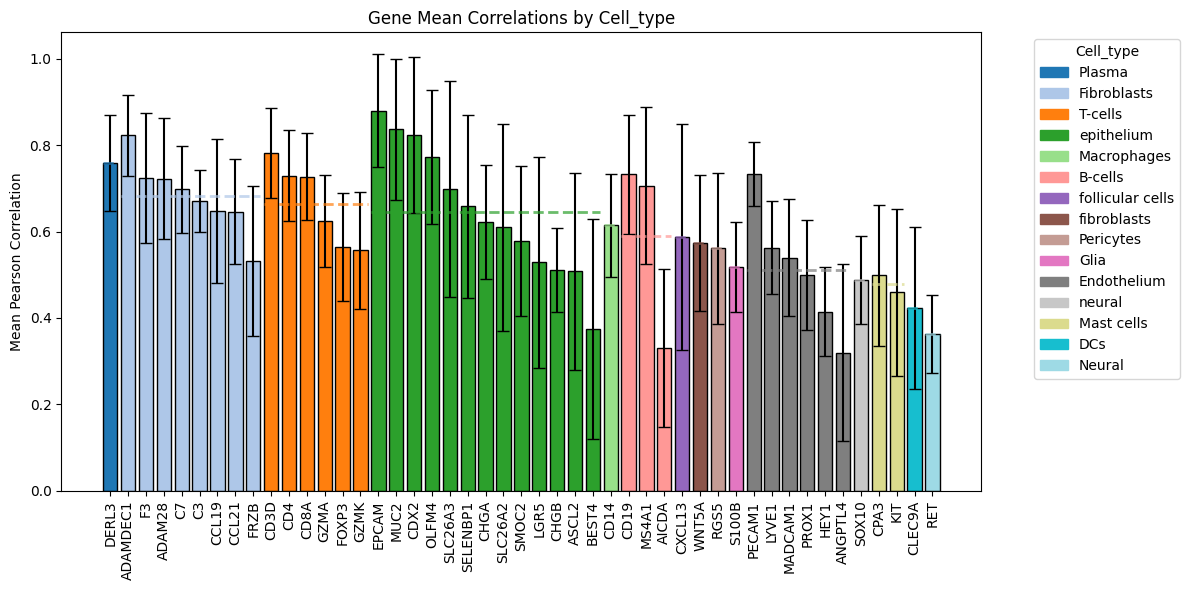

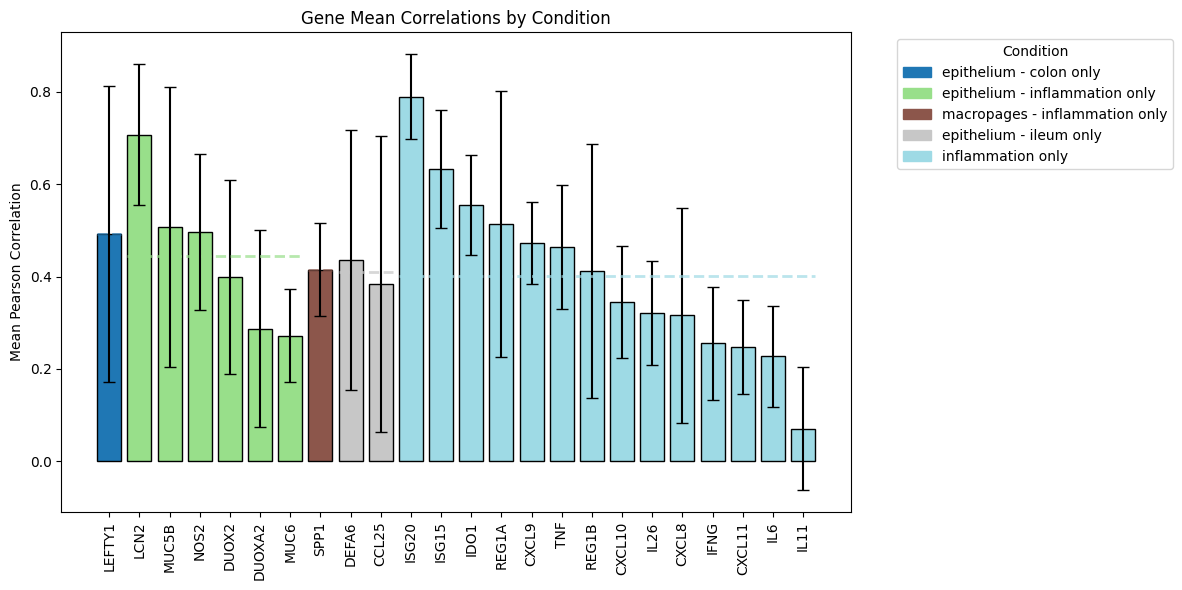

In [188]:
plot3 = plot_genes_grouped(df_genes_full_panel_annotated)
plot4 = plot_genes_grouped(df_genes_full_panel_annotated, group_by = 'condition')

# Analyse results per fold

In [189]:
## create df showing test samples for each split
import os
import glob
import pandas as pd

def get_test_splits(dataset="XeniumPR1", 
                    splits_dir="/project/simmons_hts/kxu/hest/eval/data"):
    """
    Extract test samples per split from test_*.csv files.

    Args:
        dataset (str): Dataset name (e.g., "XeniumPR1").
        splits_dir (str): Base directory where dataset splits are stored.

    Returns:
        pd.DataFrame: DataFrame with columns ["split", "test_sample"].
    """
    dataset_split_dir = os.path.join(splits_dir, dataset, "splits")
    test_files = sorted(glob.glob(os.path.join(dataset_split_dir, "test_*.csv")))

    records = []
    for test_file in test_files:
        split_num = int(os.path.basename(test_file).replace("test_", "").replace(".csv", ""))
        df_split = pd.read_csv(test_file, sep=",") 
        for sample in df_split["sample_id"].tolist():
            records.append({"split": split_num, "test_sample": sample})

    return pd.DataFrame(records)

df_test_splits = get_test_splits("XeniumPR1")
df_test_splits

metadata = pd.read_csv('/project/simmons_hts/kxu/hest/hest_directory.csv')

# Merge on test_sample <-> Sample_ID
metadata = df_test_splits.merge(
    metadata,
    left_on="test_sample",
    right_on="SampleID",
    how="left"  # keep all test samples, even if not found in metadata
).drop(columns=["SampleID"])

metadata

,split,test_sample,Technology,Patient ID,Run,Sample_type,Slide,Slide_ID,Roi,Location,Directory,PostHnE,alignment,Run_number,Directory_xenium_output,Num_patches
0,0,XeniumPR1S1ROI1,10x Xenium,CAM006,RUNTrexBIO,Healthy,1,43739,ROI1,Colon,/project/simmons_hts/jpark/1_project/0_xenium/...,CAM006_Xenium5K_post_HnE.ome.tif,CAM006_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,762
1,1,XeniumPR1S1ROI4,10x Xenium,GI9077,RUNTrexBIO,UC inflamed,1,43739,ROI4,Colon,/project/simmons_hts/jpark/1_project/0_xenium/...,GI9077_Xenium5K_post_HnE.ome.tif,GI9077_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,1264
2,10,XeniumPR1S2ROI3,10x Xenium,GI7051,RUNTrexBIO,CD inlfamed,2,43720,ROI3,Ileum,/project/simmons_hts/jpark/1_project/0_xenium/...,GI7051_Xenium5K_post_HnE.ome.tif,GI7051_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,1556
3,11,XeniumPR1S2ROI2,10x Xenium,GI9662,RUNTrexBIO,CD inlfamed,2,43720,ROI2,Ileum,/project/simmons_hts/jpark/1_project/0_xenium/...,GI9662_Xenium5K_post_HnE.ome.tif,GI9662_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,2383
4,12,XeniumPR1S2ROI5,10x Xenium,TIP522,RUNTrexBIO,Healthy,2,43720,ROI5,Ileum,/project/simmons_hts/jpark/1_project/0_xenium/...,TIP522_Xenium5K_post_HnE.ome.tif,TIP522_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,892
5,13,XeniumPR1S2ROI6,10x Xenium,TIP815,RUNTrexBIO,CD inlfamed,2,43720,ROI6,Ileum,/project/simmons_hts/jpark/1_project/0_xenium/...,TIP815_Xenium5K_post_HnE.ome.tif,TIP815_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,1640
6,14,XeniumPR1S2ROI7,10x Xenium,TIP864,RUNTrexBIO,CD inlfamed,2,43720,ROI7,Ileum,/project/simmons_hts/jpark/1_project/0_xenium/...,TIP864_Xenium5K_post_HnE.ome.tif,TIP864_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,1868
7,2,XeniumPR1S1ROI3,10x Xenium,GI9389,RUNTrexBIO,UC inflamed,1,43739,ROI3,Colon,/project/simmons_hts/jpark/1_project/0_xenium/...,GI9389_Xenium5K_post_HnE.ome.tif,GI9389_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,1232
8,3,XeniumPR1S1ROI5,10x Xenium,GI9612,RUNTrexBIO,Healthy,1,43739,ROI5,Colon,/project/simmons_hts/jpark/1_project/0_xenium/...,GI9612_Xenium5K_post_HnE.ome.tif,GI9612_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,893
9,4,XeniumPR1S1ROI7,10x Xenium,GI9613,RUNTrexBIO,UC inflamed,1,43739,ROI7,Colon,/project/simmons_hts/jpark/1_project/0_xenium/...,GI9613_Xenium5K_post_HnE.ome.tif,GI9613_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,2425


In [190]:
df_genes_full_panel_annotated

,gene,mean_corr,std_corr,corr_per_split,cell_type,condition
0,EPCAM,0.880192,0.130616,"[0.9614250053485429, 0.8554476589197699, 0.943...",epithelium,NaN
1,FCGBP,0.874212,0.104080,"[0.9622005431221452, 0.8199054866946867, 0.938...",NaN,NaN
2,CDH1,0.855118,0.142134,"[0.9579847840197014, 0.6874527435595037, 0.933...",NaN,NaN
3,MUC2,0.836970,0.163474,"[0.9367316596674853, 0.8545906061262525, 0.926...",epithelium,NaN
4,PTPRC,0.826504,0.079118,"[0.866304864878388, 0.8596610288881009, 0.8661...",NaN,NaN
...,...,...,...,...,...,...
358,IGF2BP1,0.130389,0.067986,"[0.13093603569478346, 0.04851848974870358, 0.2...",NaN,NaN
359,MSLN,0.129950,0.106789,"[0.3257072309825532, 0.11897649330354831, 0.14...",NaN,NaN
360,WT1,0.103433,0.074384,"[0.12205286424033254, 0.019438738686855476, 0....",NaN,NaN
361,FGFBP2,0.102013,0.102774,"[0.01286588517257961, 0.037469260015991004, 0....",NaN,NaN


In [191]:
def tidy_gene_corrs(df_genes):
    """
    Convert df_genes with corr_per_split list column into tidy long format.

    Args:
        df_genes (pd.DataFrame): with columns [gene, mean_corr, std_corr, corr_per_split]

    Returns:
        pd.DataFrame: long format with columns [gene, split, correlation, mean_corr, std_corr]
    """
    import pandas as pd
    
    # Explode list into rows
    df_long = df_genes.explode("corr_per_split").reset_index(drop=True)
    
    # Add split index (since explode loses it)
    df_long["split"] = df_long.groupby("gene").cumcount()
    
    # Rename corr_per_split column to correlation
    df_long = df_long.rename(columns={"corr_per_split": "corr"})
    
    return df_long

In [192]:
df_genes_annotated_long = tidy_gene_corrs(df_genes_full_panel_annotated)
df_genes_annotated_long

,gene,mean_corr,std_corr,corr,cell_type,condition,split
0,EPCAM,0.880192,0.130616,0.961425,epithelium,NaN,0
1,EPCAM,0.880192,0.130616,0.855448,epithelium,NaN,1
2,EPCAM,0.880192,0.130616,0.943762,epithelium,NaN,2
3,EPCAM,0.880192,0.130616,0.938763,epithelium,NaN,3
4,EPCAM,0.880192,0.130616,0.825881,epithelium,NaN,4
...,...,...,...,...,...,...,...
5440,IL11,0.070639,0.132808,0.270445,NaN,inflammation only,10
5441,IL11,0.070639,0.132808,0.065178,NaN,inflammation only,11
5442,IL11,0.070639,0.132808,-0.056868,NaN,inflammation only,12
5443,IL11,0.070639,0.132808,-0.006168,NaN,inflammation only,13


In [193]:
# mean correlation per split across all genes
df_genes_annotated_long.groupby("split")["corr"].mean() 

split
0      0.62298
1     0.403805
2     0.567317
3     0.609662
4     0.364421
5     0.495103
6     0.624219
7     0.454369
8     0.599751
9     0.550225
10    0.488026
11    0.591312
12    0.569744
13    0.380919
14    0.568411
Name: corr, dtype: object

In [194]:
# mean correlation per split per cell type
df_genes_annotated_long.groupby(["split",'cell_type'])["corr"].mean() 

split  cell_type       
0      B-cells             0.678385
       DCs                 0.631347
       Endothelium         0.542909
       Fibroblasts         0.806492
       Glia                0.537556
                             ...   
14     T-cells             0.765297
       epithelium          0.688289
       fibroblasts         0.647042
       follicular cells     0.64008
       neural              0.429506
Name: corr, Length: 225, dtype: object

In [195]:
# mean correlation per split per condition
df_genes_annotated_long.groupby(["split",'condition'])["corr"].mean() 

split  condition                     
0      epithelium - colon only           0.898691
       epithelium - ileum only           0.094423
       epithelium - inflammation only    0.470944
       inflammation only                 0.345096
       macropages - inflammation only    0.414989
                                           ...   
14     epithelium - colon only           0.162138
       epithelium - ileum only           0.801734
       epithelium - inflammation only    0.256327
       inflammation only                 0.424068
       macropages - inflammation only    0.459503
Name: corr, Length: 75, dtype: object

In [196]:
def merge_corrs_with_metadata(df_long, df_metadata):
    """
    Merge long-format gene correlation DataFrame with metadata.

    Args:
        df_long (pd.DataFrame): columns [gene, split, correlation, mean_corr, std_corr]
        df_metadata (pd.DataFrame): must contain [split, test_sample, Sample_type, Location]

    Returns:
        pd.DataFrame
    """
    df = df_long.merge(df_metadata, on="split", how="left")
    return df

In [197]:
# Merge with metadata
df_genes_annotated_long_metadata = merge_corrs_with_metadata(df_genes_annotated_long, metadata)
display(df_genes_annotated_long_metadata)
df_genes_annotated_long_metadata.columns

,gene,mean_corr,std_corr,corr,cell_type,condition,split,test_sample,Technology,Patient ID,...,Slide,Slide_ID,Roi,Location,Directory,PostHnE,alignment,Run_number,Directory_xenium_output,Num_patches
0,EPCAM,0.880192,0.130616,0.961425,epithelium,NaN,0,XeniumPR1S1ROI1,10x Xenium,CAM006,...,1,43739,ROI1,Colon,/project/simmons_hts/jpark/1_project/0_xenium/...,CAM006_Xenium5K_post_HnE.ome.tif,CAM006_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,762
1,EPCAM,0.880192,0.130616,0.855448,epithelium,NaN,1,XeniumPR1S1ROI4,10x Xenium,GI9077,...,1,43739,ROI4,Colon,/project/simmons_hts/jpark/1_project/0_xenium/...,GI9077_Xenium5K_post_HnE.ome.tif,GI9077_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,1264
2,EPCAM,0.880192,0.130616,0.943762,epithelium,NaN,2,XeniumPR1S1ROI3,10x Xenium,GI9389,...,1,43739,ROI3,Colon,/project/simmons_hts/jpark/1_project/0_xenium/...,GI9389_Xenium5K_post_HnE.ome.tif,GI9389_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,1232
3,EPCAM,0.880192,0.130616,0.938763,epithelium,NaN,3,XeniumPR1S1ROI5,10x Xenium,GI9612,...,1,43739,ROI5,Colon,/project/simmons_hts/jpark/1_project/0_xenium/...,GI9612_Xenium5K_post_HnE.ome.tif,GI9612_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,893
4,EPCAM,0.880192,0.130616,0.825881,epithelium,NaN,4,XeniumPR1S1ROI7,10x Xenium,GI9613,...,1,43739,ROI7,Colon,/project/simmons_hts/jpark/1_project/0_xenium/...,GI9613_Xenium5K_post_HnE.ome.tif,GI9613_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,2425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5440,IL11,0.070639,0.132808,0.270445,NaN,inflammation only,10,XeniumPR1S2ROI3,10x Xenium,GI7051,...,2,43720,ROI3,Ileum,/project/simmons_hts/jpark/1_project/0_xenium/...,GI7051_Xenium5K_post_HnE.ome.tif,GI7051_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,1556
5441,IL11,0.070639,0.132808,0.065178,NaN,inflammation only,11,XeniumPR1S2ROI2,10x Xenium,GI9662,...,2,43720,ROI2,Ileum,/project/simmons_hts/jpark/1_project/0_xenium/...,GI9662_Xenium5K_post_HnE.ome.tif,GI9662_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,2383
5442,IL11,0.070639,0.132808,-0.056868,NaN,inflammation only,12,XeniumPR1S2ROI5,10x Xenium,TIP522,...,2,43720,ROI5,Ileum,/project/simmons_hts/jpark/1_project/0_xenium/...,TIP522_Xenium5K_post_HnE.ome.tif,TIP522_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,892
5443,IL11,0.070639,0.132808,-0.006168,NaN,inflammation only,13,XeniumPR1S2ROI6,10x Xenium,TIP815,...,2,43720,ROI6,Ileum,/project/simmons_hts/jpark/1_project/0_xenium/...,TIP815_Xenium5K_post_HnE.ome.tif,TIP815_Xenium5K_post_HnE_matrix.csv,1,/project/simmons_hts/shared/20_11_2024_xenium_...,1640


Index(['gene', 'mean_corr', 'std_corr', 'corr', 'cell_type', 'condition',
       'split', 'test_sample', 'Technology', 'Patient ID', 'Run',
       'Sample_type', 'Slide', 'Slide_ID', 'Roi', 'Location', 'Directory',
       'PostHnE', 'alignment', 'Run_number', 'Directory_xenium_output',
       'Num_patches'],
      dtype='object')

In [198]:
def plot_corrs_by_sample(
    df,
    group_by="Sample_type",
    split_by=None
):
    """
    Plot per-split gene correlations grouped by metadata, and return the figure object.

    Args:
        df (pd.DataFrame): must contain columns:
            [split, gene, corr, test_sample, Sample_type, Location, cell_type, condition]
        group_by (str): column to group samples by ('Sample_type' or 'Location')
        split_by (str or None): if set to 'cell_type' or 'condition',
            further split boxplots inside each test_sample.

    Returns:
        matplotlib.figure.Figure: figure object for further saving or manipulation.
    """
    if group_by not in df.columns:
        raise ValueError(f"{group_by} must be a column in df")
    if split_by and split_by not in df.columns:
        raise ValueError(f"{split_by} must be a column in df")

    df = df.copy()
    # Create x-axis label
    df["x_label"] = df.apply(lambda r: f"{r[group_by]} | {r['test_sample']}" if split_by else r["test_sample"], axis=1)

    # Order groups by mean correlation
    group_means = df.groupby(group_by)["corr"].mean().sort_values(ascending=False)
    group_order = group_means.index.tolist()
    x_order = []
    for grp in group_order:
        samples = df[df[group_by] == grp]["x_label"].drop_duplicates().tolist()
        x_order.extend(samples)
    df["x_label"] = pd.Categorical(df["x_label"], categories=x_order, ordered=True)

    # Plot
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.boxplot(
        data=df,
        x="x_label",
        y="corr",
        hue=split_by if split_by else group_by,
        dodge=True if split_by else False,
        showfliers=False,
        palette="tab20",
        ax=ax
    )
    plt.xticks(rotation=60, ha="right")
    ax.set_ylabel("Gene Correlation")
    ax.set_xlabel(f"Test Sample (grouped by {group_by})")

    title = f"Per-Split Gene Correlations Grouped by {group_by}"
    if split_by:
        title += f", Split by {split_by}"
        ax.legend(title=split_by, bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax.legend(title=group_by, bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_title(title)
    plt.tight_layout()

    return fig

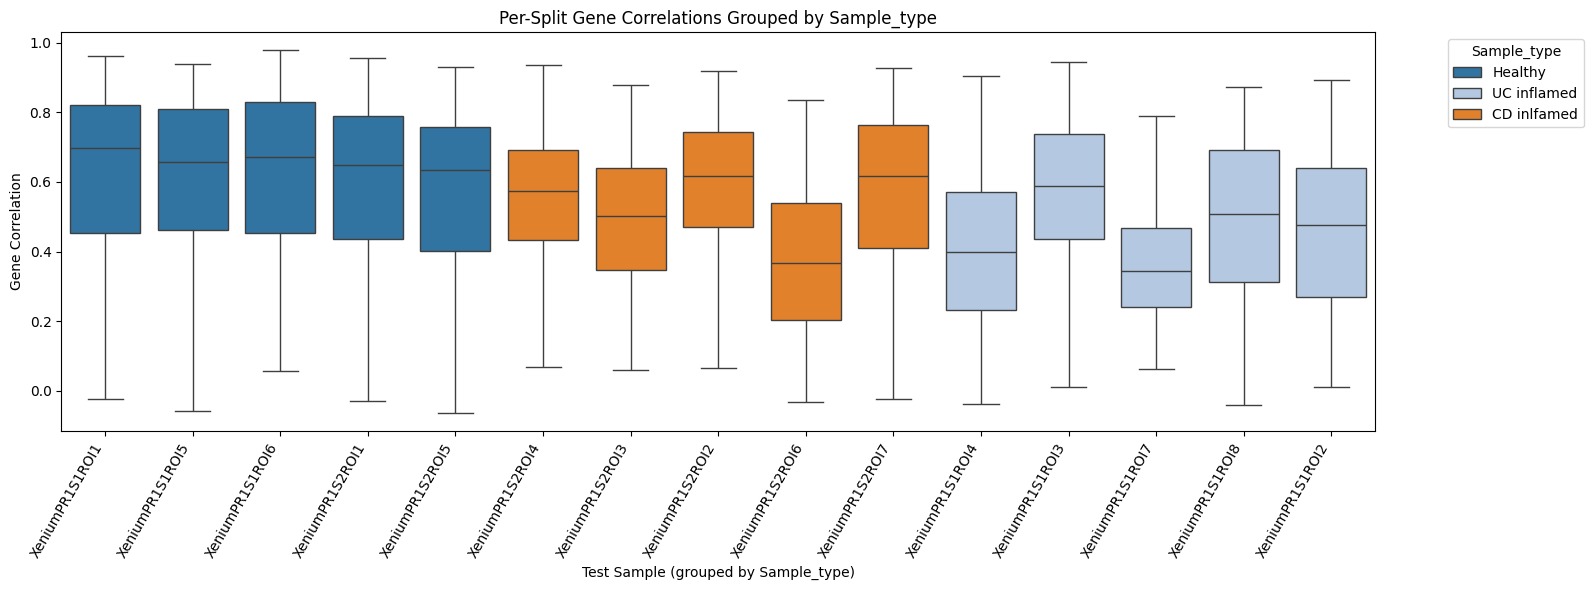

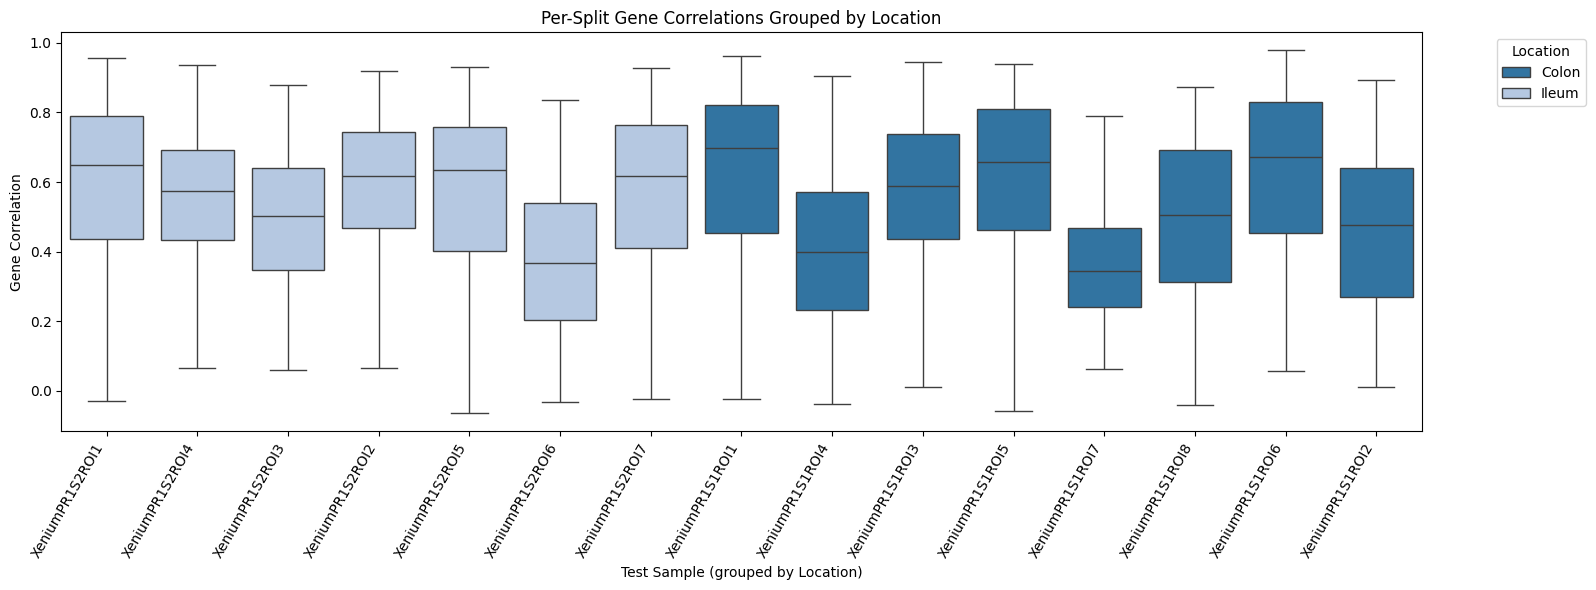

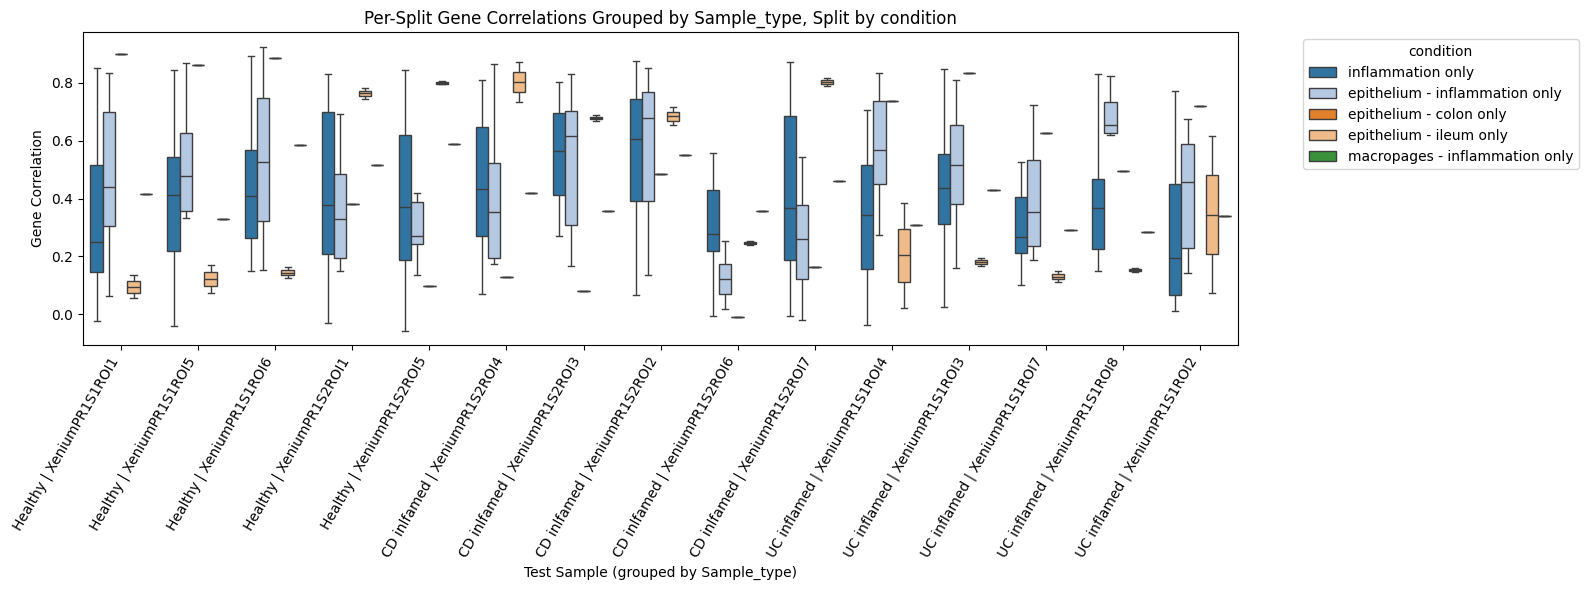

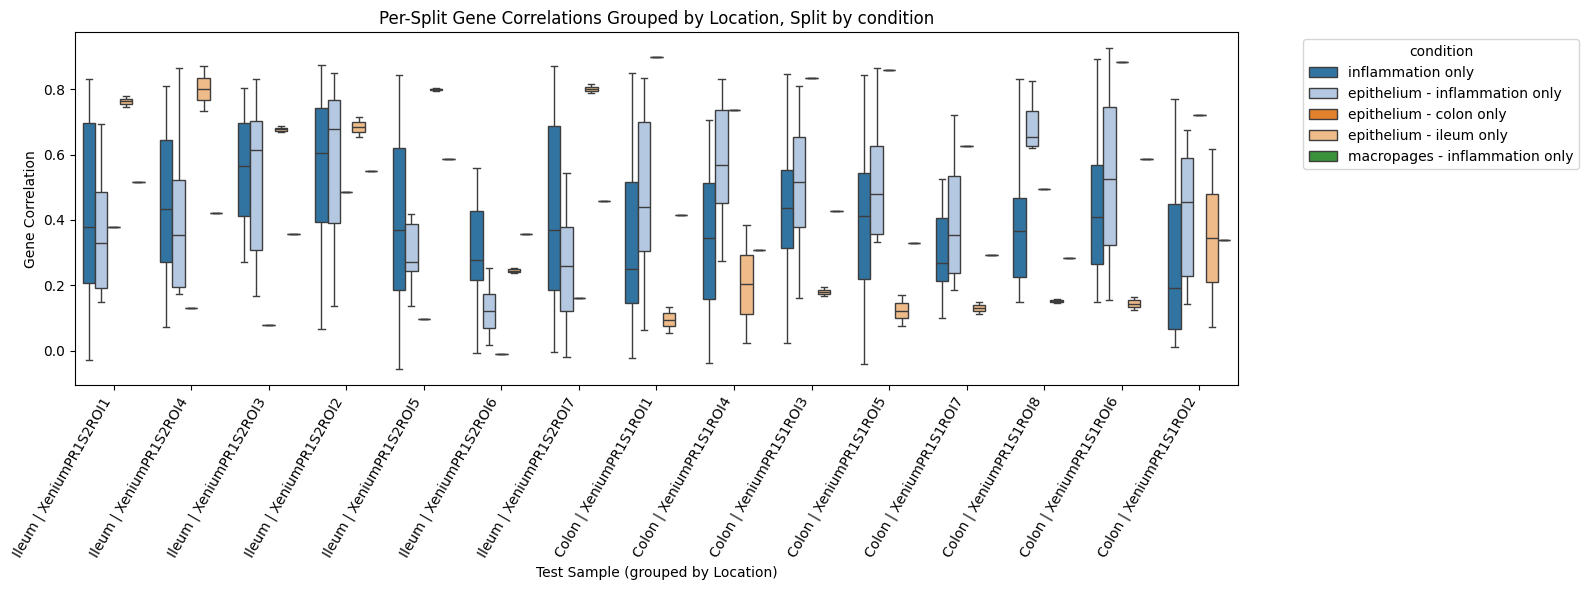

In [199]:
# Plot grouped by Sample_type
plot5 = plot_corrs_by_sample(df_genes_annotated_long_metadata, group_by="Sample_type")

# Plot grouped by Location
plot6 = plot_corrs_by_sample(df_genes_annotated_long_metadata, group_by="Location")

plot7 = plot_corrs_by_sample(df_genes_annotated_long_metadata, group_by="Sample_type", split_by = 'condition')
plot8 = plot_corrs_by_sample(df_genes_annotated_long_metadata, group_by="Location", split_by = 'condition')

In [200]:
# Select the run 
RUN = df_summary.loc[RUN_INDEX, 'run']  # wrap in list to match expected format
print("Selected RUNS:", RUN)

Selected RUNS: run_25-09-06-14-12-40


In [201]:
import os
from matplotlib.backends.backend_pdf import PdfPages

# Assume you already have the plots: plot1, plot2, ..., plot8 (matplotlib Figure objects)
plots = [plot0, plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8]

# Get run folder path
run_folder = os.path.join(DEFAULT_ROOT_DIR, RUN)
os.makedirs(run_folder, exist_ok=True)

# Output PDF path
pdf_path = os.path.join(run_folder, f"plots.pdf")

# Save all plots as pages in one PDF
with PdfPages(pdf_path) as pdf:
    for fig in plots:
        if fig:  # skip any None figures
            pdf.savefig(fig)
            plt.close(fig)  # close the figure after saving to free memory

print(f"Saved all plots to {pdf_path}")

Saved all plots to /project/simmons_hts/kxu/hest/eval/ST_pred_results/run_25-09-06-14-12-40/plots.pdf
